In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats as st

In [7]:
import random
import tensorflow as tf

In [18]:
# Test code
len = 10
eps = 20
y_true = np.array([[np.round(random.random()) for i in range(len)] for e in range(eps)])
y_pred = np.array([[np.round(random.random()) for i in range(len)] for e in range(eps)])

# MAE functions
def mae_std(y_true, y_pred):
  ep_ref_tc = tf.reduce_sum(y_true, axis=1)
  ep_pred_tc = tf.reduce_sum(y_pred, axis=1)
  ep_diff = np.abs(ep_ref_tc - ep_pred_tc)
  ep_rel_diff = ep_diff/ep_ref_tc
  mae_std = np.mean(ep_rel_diff)

  return mae_std

mae_std(y_true, y_pred)

0.33152777777777775

## Threshold Solution:
- Get cos sim for each sentence in each episode
- For each episode, figure out which Z value would provide the right amount of expected topics


Dataset: yt_scripts_segments_split_n3_111422
Embedding: all-MiniLM-L6-v2-meanpooling, Mean Z Value: -1.785378202653044
Embedding: universal-sentence-encoder-large-5-meanpooling, Mean Z Value: -1.5929829129986828
Embedding: universal-sentence-encoder-4-meanpooling, Mean Z Value: -1.6571476660700355
Embedding: stsb-mpnet-base-v2-meanpooling, Mean Z Value: -1.6275604430594255

Dataset: yt_scripts_segments_split_n5_111422
Embedding: all-MiniLM-L6-v2-meanpooling, Mean Z Value: -1.6650637816977294
Embedding: universal-sentence-encoder-large-5-meanpooling, Mean Z Value: -1.5373253438624186
Embedding: universal-sentence-encoder-4-meanpooling, Mean Z Value: -1.583446130269857
Embedding: stsb-mpnet-base-v2-meanpooling, Mean Z Value: -1.5468645419901283

Dataset: yt_scripts_segments_split_n10_112922
Embedding: all-MiniLM-L6-v2-meanpooling, Mean Z Value: -1.320362446263225
ERROR_No_Sims_Found --- Embedding: universal-sentence-encoder-large-5-meanpooling
ERROR_No_Sims_Found --- Embedding: universa

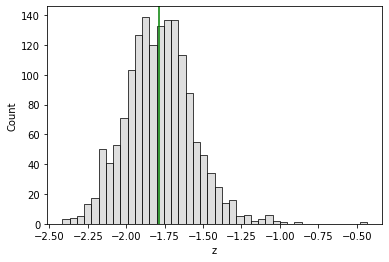

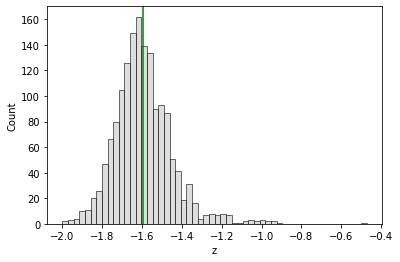

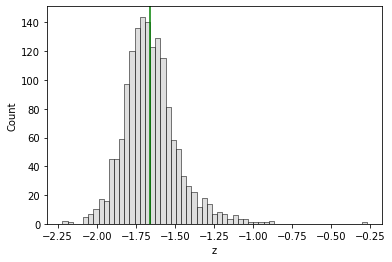

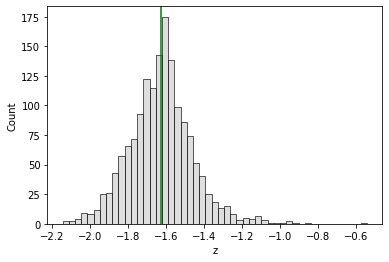

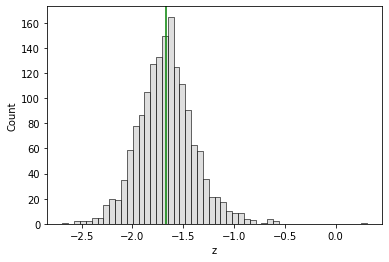

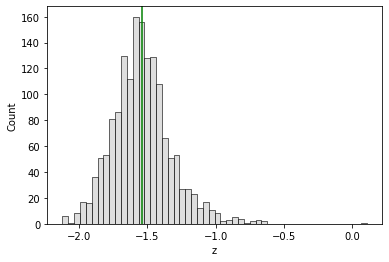

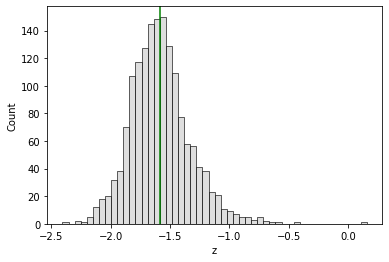

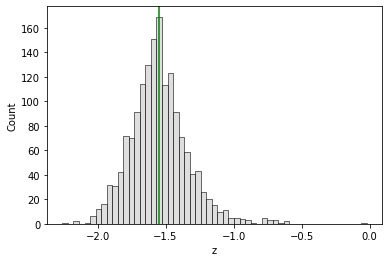

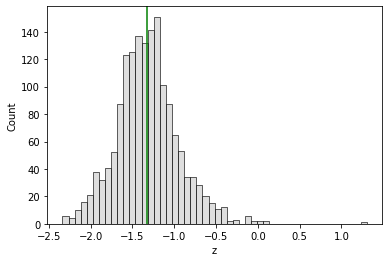

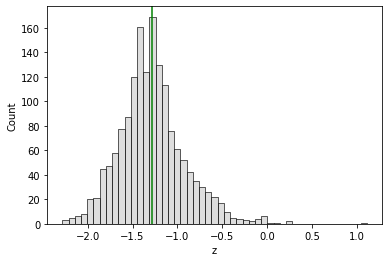

In [ ]:
ds_list = ['yt_scripts_segments_split_n3_111422', 
           'yt_scripts_segments_split_n5_111422',
           'yt_scripts_segments_split_n10_112922'
           ]
embed_list = ['all-MiniLM-L6-v2-meanpooling',
              'universal-sentence-encoder-large-5-meanpooling',
              'universal-sentence-encoder-4-meanpooling',
              'stsb-mpnet-base-v2-meanpooling']

for dataset in ds_list:
  print(f"\nDataset: {dataset}")
  for pooling in embed_list:
      try:
        path = '/content/drive/MyDrive/nlp_podcast_segmentation/'
        yt_path = path + 'data/YouTube/'
        if (pooling == 'all-MiniLM-L6-v2-meanpooling') | (dataset == 'yt_scripts_segments_split_n10_112922'):
          sims_path = yt_path + f'metrics_results/{dataset}/{pooling}-WS4-Z1.6-all/'
        else:
          sims_path = yt_path + f'metrics_results/{dataset}/{pooling}/'

        # Load train set
        with open(f"{yt_path}ep_splits.json", 'r') as f:
            splits = json.load(f)
        df = pd.read_pickle(f'{yt_path}{dataset}.csv')
        train = df.loc[df['Video_Id'].isin(splits['train'])].copy()

        # Get the cos sims for each episode
        sims = np.load(sims_path + f'sims_list_{pooling}.npy', allow_pickle=True)
        y_hats = np.load(sims_path + f'Y_hat_list_{pooling}.npy', allow_pickle=True)
        res = pd.read_csv(sims_path + f'results_{pooling}.csv', header=None)
        res['sims'] = sims
        res.columns = ['date', 'Video_Id', 'm1', 'm2', 'sims']

        # Merge into train df
        train['num_topics'] = train['Transition_Labels'].apply(lambda x: np.sum(x))
        train['num_sents'] = train['Transition_Labels'].apply(lambda x: len(x))
        train_sims = pd.merge(train, res, on='Video_Id', how='inner')

        # Get Z value for each episode
        train_sims['z'] = train_sims.apply(lambda x: np.sort(st.zscore(x['sims']))[int(x['num_topics'])], axis=1)

        # Visualize distribution
        mean_z = np.mean(train_sims['z'])
        print(f"Embedding: {pooling}, Mean Z Value: {mean_z}")
        fig, ax = plt.subplots()
        plt.axvline(mean_z, 0, 40, color='green')
        sns.histplot(train_sims['z'], color='lightgray')
      except:
        print(f"ERROR_No_Sims_Found --- Embedding: {pooling}")

In [ ]:
# Visualize distribution of num_sents
mean_sents = np.mean(train['num_sents'])
print(f"Dataset: {dataset}, Mean Num Sents: {mean_sents}")
fig, ax = plt.subplots()
plt.axvline(mean_sents, 0, 40, color='green')
sns.histplot(train['num_sents'], color='lightgray')

NameError: ignored

Embedding: universal-sentence-encoder-4-meanpooling, Mean Z Value: -1.2861183195672832


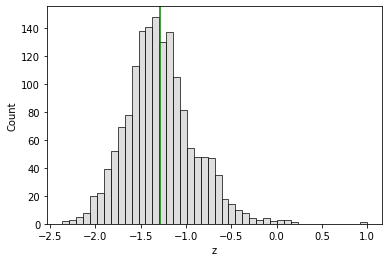

In [4]:
dataset = 'yt_scripts_segments_split_n10_112922'
pooling = 'universal-sentence-encoder-4-meanpooling'
path = '/content/drive/MyDrive/nlp_podcast_segmentation/'
yt_path = path + 'data/YouTube/'
sims_path = yt_path + f'metrics_results/{dataset}/{pooling}-WS4-Z1.0-all/'

# Load train set
with open(f"{yt_path}ep_splits.json", 'r') as f:
    splits = json.load(f)
df = pd.read_pickle(f'{yt_path}{dataset}.csv')
train = df.loc[df['Video_Id'].isin(splits['train'])].copy()

# Get the cos sims for each episode
sims = np.load(sims_path + f'sims_list_{pooling}.npy', allow_pickle=True)
y_hats = np.load(sims_path + f'Y_hat_list_{pooling}.npy', allow_pickle=True)
res = pd.read_csv(sims_path + f'results_{pooling}.csv', header=None)
res['sims'] = sims
res.columns = ['date', 'Video_Id', 'm1', 'm2', 'sims']

# Merge into train df
train['num_topics'] = train['Transition_Labels'].apply(lambda x: np.sum(x))
train['num_sents'] = train['Transition_Labels'].apply(lambda x: len(x))
train_sims = pd.merge(train, res, on='Video_Id', how='inner')

# Get Z value for each episode
train_sims['z'] = train_sims.apply(lambda x: np.sort(st.zscore(x['sims']))[int(x['num_topics'])], axis=1)

# Visualize distribution
mean_z = np.mean(train_sims['z'])
print(f"Embedding: {pooling}, Mean Z Value: {mean_z}")
fig, ax = plt.subplots()
plt.axvline(mean_z, 0, 40, color='green')
sns.histplot(train_sims['z'], color='lightgray')

In [ ]:
# # Get Z value for one episode
# ep1 = train_sims.iloc[0].copy()
# z1 = np.sort(st.zscore(ep1['sims']))[int(ep1['num_topics'])]
# print(z1)

# # Visualize
# fig, ax = plt.subplots()
# sns.histplot(ep1['sims'], color='lightgray')
# plt.title("Distribution of Similarities")
# plt.axvline(np.mean(ep1['sims']), 0, 40, color='green')
# plt.axvline(np.mean(ep1['sims'])-np.std(ep1['sims']), 0, 40, color='purple')
# plt.axvline(np.mean(ep1['sims'])+z1*np.std(ep1['sims']), 0, 40, color='orange')

In [ ]:
# ## Visualize errors of method 2
# train_sims['exp_topics_2'] = \
#   train_sims['sims'].apply(lambda x: np.sum(x < (np.mean(x) + mean_z*np.std(x))))

# train_sims['diff_topics_2'] = train_sims['exp_topics_2'] - train_sims['num_topics']
# print(f"Mean error: {np.mean(train_sims['diff_topics_2'])}")
# mae = mean_absolute_error(train_sims['num_topics'], train_sims['exp_topics_2'])
# print(f"Mean absolute error: {mae}")

# sns.histplot(train_sims['diff_topics_2'].values)

In [ ]:
# train_sims['diff_topics_perc_2'] = train_sims['diff_topics_2']/train_sims['num_topics']
# print(np.mean(np.abs(train_sims['diff_topics_perc_2'])))
# sns.histplot(train_sims['diff_topics_perc_2'].values)